<a href="https://colab.research.google.com/github/gitudaniel/data-science-notes/blob/main/Pet_breeds_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade fastai

     |████████████████████████████████| 204kB 35.5MB/s 
     |████████████████████████████████| 61kB 8.4MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
import fastai
fastai.__version__

'2.3.1'

In [3]:
pip install fastbook

     |████████████████████████████████| 727kB 27.9MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 1.2MB 23.0MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 


In [4]:
from fastai.vision.all import *
from fastbook import *

In [5]:
path = untar_data(URLs.PETS)

- To understand how to extract the breed of each pet from each image, we're going to need to understand how this data is laid out.

- Data is usually provided in two ways:
  - Individual files representing items of data, such as text documents or images, possibly organised into folders or with filenames representing information about those items.
  - A table of data e.g. CSV, where each row is an item.

- While there are exceptions, the vast majority of datasets use some combination of the above two formats.

- To see what's in our dataset, we can use the `ls` method

In [6]:
# When printing out the output of ls show the name relative to path
Path.BASE_PATH = path

In [7]:
path.ls()

(#2) [Path('annotations'),Path('images')]

- This dataset provides us with "images" and "annotations" directories.

- The annotations directory contains information about where the pets are.

- Since our problem is classification and not localization (we care about what the pets are not where they are), we will ignore the annotations directory for now.

In [8]:
(path/"images").ls()

(#7393) [Path('images/german_shorthaired_104.jpg'),Path('images/Sphynx_126.jpg'),Path('images/yorkshire_terrier_190.jpg'),Path('images/english_cocker_spaniel_200.jpg'),Path('images/newfoundland_167.jpg'),Path('images/havanese_9.jpg'),Path('images/Bombay_66.jpg'),Path('images/Birman_179.jpg'),Path('images/english_cocker_spaniel_81.jpg'),Path('images/British_Shorthair_188.jpg')...]

- Most functions and methods in fastai which return a collection use a class called `L`.

- `L` can be thought of as an enhanced version of the Python `list` type, with added conveniences for common operations.

- When we display an object of this class in a notebook, the first thing that appears is the number of items in the collection, prefixed with a `#`.

- The list is suffixed with a "`...`" meaning that only the first few items are displayed.

- By examining these filenames, we notice that each file name contains the pet breed, an `_` character, a number and finally the file extension.

- We need to create code that extracts the breed from a single `Path`.

In [9]:
fname = (path/"images").ls()[0]

In [10]:
fname

Path('images/german_shorthaired_104.jpg')

- The most powerful and flexible way to extract information from strings is to use a *regular expression (regex)*.

- In this case, we need a regular expression that extracts the pet breed from the filename.

In [11]:
re.findall(r'(.+)_\d+\.jpg$', fname.name)

['german_shorthaired']

- The regular expression above picks all the characters leading up to the underscore character that is followed by numerical digits and the jpeg file extension.

- Now that we've confirmed the regular expression works for the example, let's use it to label the whole dataset.

- For labelling with regular expressions, we can use the `RegexLabeller` class within the data block API

In [12]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))

dls = pets.dataloaders(path/"images")

- In our DataBlock, the independent variables are images (ImageBlock) and the dependent variables are categories (CategoryBlock).

- `aug_transforms` gives us different perspectives of the data. Think of it as synthetically generating new data from the data we have i.e. increasing brightness, changing the image perspective etc.

- The `size` argument to `aug_transforms` uses RandomResizeCrop to resize the image to a smaller size.

- We resize our images to a large image (by deep learning standards) then we use `aug_transforms` with a size.

- This combination of steps constitutes `presizing`.

- `Presizing` is a way to do image augmentation, which is designed to minimize data destruction while maintaining good performance.

## Checking and debugging a DataBlock

- Checking your data looks right is extremely important before training a model.

- We use the `show_batch` method to have a look at our data

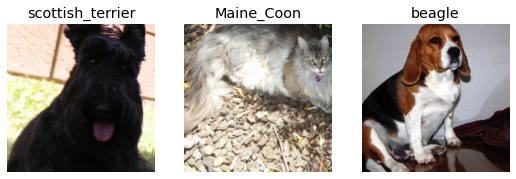

In [13]:
dls.show_batch(nrows=1, ncols=3)

- Adding `unique=True` is a good way to see if the data augmentation is working.

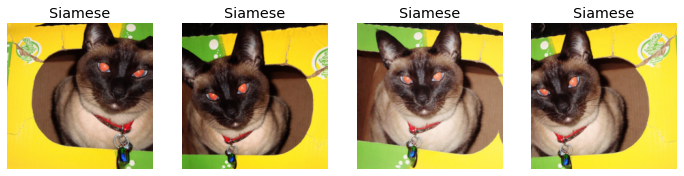

In [14]:
dls.show_batch(nrows=1, ncols=4, unique=True)

- If you make a mistake while building your `DataBlock` it is very likely you won't see it before this step.

- To debug, you could use the `summary` method.

- It attempts to create a batch with a lot of details from the source you give it.

- Also, if it fails, you will see exactly at which point the error happens, and the library will try to give you some help.

In [15]:
# pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
#                   get_items=get_image_files,
#                   splitter=RandomSplitter(seed=42),
#                   get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))
# pets1.summary(path/"images")

- The example above shows us that the DataBlock could not collate the images because the images were of different sizes.

- This means that we forgot to add a `resize` parameter.


- Once you think the data looks right, the next step should be creating a simple model.

- You'd want to know as early as possible whether the data requires a lot of fancy domain specific engineering, or whether the data trains at all.

In [16]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.506041,0.334921,0.102165,01:08


epoch,train_loss,valid_loss,error_rate,time
0,0.468075,0.318150,0.098106,01:11
1,0.322410,0.232792,0.071042,01:12


In [17]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

- The table shown when we fit a model shows us the result after each epoch of training.

- An epoch is one complete pass through all of the images in the data.

- The columns shown are the average loss over all the items of the training set, the loss on the validation set, and any metrics that you requested -- in this case, the error rate.

- *Loss* is whatever function we've decided to use to optimise the parameters of our model.

- In our case we haven't actually told fastai what loss function we want to use.

- Fastai will generally try to select an appropriate loss function based on what kind of data and model you are using.

- In our case, we have image data and a categorical outcome, so fastai will default to using *cross entropy loss*

## Cross entropy loss

- *Cross entropy loss* is a loss function which is similar to the loss function we used with the mnist dataset, but has two benefits:
  - It works even when our dependent variable has more than two categories
  - It results in faster and more reliable training

- In order to understand how cross entropy loss works for dependent variables with more than two categories, we first have to understand what the actual data and activations seen by the loss function look like.

### Viewing activations and labels

- To get a batch of real data from our DataLoaders, we can use the `one_batch` method which returns the dependent and independent variables as a mini-batch

In [18]:
# first(dls.train) is another alternative that does the same thing
x, y = dls.one_batch()

In [19]:
y

TensorCategory([19, 31, 30,  2,  7, 10,  1, 24, 28, 12,  2,  4, 15, 11, 19,  8,  4,  7, 13,  4, 27, 13, 32, 31, 28, 25, 36, 31,  0, 22, 17, 15,  1,  0,  4,  8, 24,  0,  9,  5,  7, 32,  4,  9, 27,  0, 35, 33,
        33, 25,  9,  4,  2, 10, 17,  0, 10, 22, 31, 28, 17,  8, 24,  2], device='cuda:0')

In [20]:
y.shape

torch.Size([64])

In [21]:
dls.vocab

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']

- Our batch size is 64, so we have 64 rows in this tensor.

- Each row is a single integer between 0 and 36 representing our 37 possible pet breeds.

- Each integer maps to the index of the pet breed in our `vocab`

In [22]:
dls.vocab[3]

'Bombay'

- We can view the predictions (i.e. the activations of the final layer of our neural network) using `Learner.get_perds`.

- This function either takes a dataset index (0 for train and 1 for validation) or an iterator of batches.

- We can pass it a simple list with our batch to get our predictions.

In [23]:
preds, targets = learn.get_preds(dl=[(x,y)])

In [24]:
targets

TensorCategory([19, 31, 30,  2,  7, 10,  1, 24, 28, 12,  2,  4, 15, 11, 19,  8,  4,  7, 13,  4, 27, 13, 32, 31, 28, 25, 36, 31,  0, 22, 17, 15,  1,  0,  4,  8, 24,  0,  9,  5,  7, 32,  4,  9, 27,  0, 35, 33,
        33, 25,  9,  4,  2, 10, 17,  0, 10, 22, 31, 28, 17,  8, 24,  2])

In [25]:
y

TensorCategory([19, 31, 30,  2,  7, 10,  1, 24, 28, 12,  2,  4, 15, 11, 19,  8,  4,  7, 13,  4, 27, 13, 32, 31, 28, 25, 36, 31,  0, 22, 17, 15,  1,  0,  4,  8, 24,  0,  9,  5,  7, 32,  4,  9, 27,  0, 35, 33,
        33, 25,  9,  4,  2, 10, 17,  0, 10, 22, 31, 28, 17,  8, 24,  2], device='cuda:0')

- You'll notice that it returns predictions and targets by default and we already have the targets in the `y` variable.

- We can effectively ignore the targets by assigning them to the special variable `_`.

In [26]:
preds, _ = learn.get_preds(dl=[(x,y)])

In [27]:
preds[0]

tensor([4.5099e-07, 2.7354e-03, 5.5158e-06, 3.0194e-05, 2.0838e-07, 1.0844e-02, 6.6131e-06, 2.2813e-06, 9.9770e-07, 2.9255e-06, 4.8274e-06, 1.1116e-06, 4.0684e-06, 3.4651e-05, 4.5421e-06, 3.8458e-05,
        5.6862e-06, 9.5563e-06, 5.4258e-04, 9.8432e-01, 8.7398e-04, 3.9355e-05, 2.5372e-06, 1.1269e-05, 5.5641e-05, 1.5859e-06, 3.9920e-06, 2.5242e-05, 6.4772e-06, 1.5923e-05, 1.3440e-06, 7.1362e-06,
        5.3885e-06, 2.1069e-06, 5.8762e-06, 9.6542e-07, 3.4609e-04])

- The actual predictions are 37 probabilities between zero and one, that add up to 1 in total.

In [28]:
len(preds[0]), preds[0].sum()

(37, tensor(1.0000))

- To transform the activations of our model into predictions like this, we use the *softmax activation function*

## Softmax

- In our classification model, an activation function called *softmax* in the final layer is used to ensure that the activations are between zero and one, and that they sum up to one

/usr/local/lib/python3.7/dist-packages/fastbook/__init__.py:73: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(min,max)


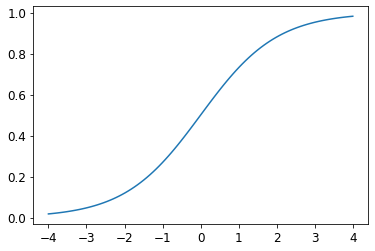

In [29]:
# sigmoid function
plot_function(torch.sigmoid, min=-4, max=4)

- Softmax is an extension of the sigmoid function to handle more than 2 categories.

- We can apply the sigmoid function to a single column of activations (predictions) from a neural network and get back a column of numbers between zero and one.

- If we have more categories in our target (such as our 37 pet breeds), we'll need more activations than just a single column: we need an activation *per category*.

- As an example we can create a neural net that predicts "3"s and "7"s that returns two activations, one for each class.

- Let's use some random numbers with a standard deviation of 2 (multiply `randn` by 2).

- For this example let's assume we have six images and two possible categories (the first column represents "3"s and the second "7"s):

In [30]:
torch.random.manual_seed(42);

In [31]:
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

- The tensor above represents a final layer with two activations.

- The first column (activation) represents how much like a "3" an image is and the second how much like a "7" it is.

In [32]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

- If we take the sigmoid of our final layer, we get two numbers between zero and one that don't add up to one.

- This doesn't make sense since every digit in that dataset is either one or the other.

- A single pair of activations simply indicates the *relative* confidence of being a "3" versus being a "7".

- The overall values, whether they are both high or low, don't matter--all that matters is which is higher and by how much.

- We can therefore take the difference between the neural net activations, because that reflects how much more sure we are of being a "3" vs a "7", and then take the sigmoid of that.

In [33]:
# difference of the first column and the second column
diff = acts[:,0] - acts[:,1]
diff

tensor([ 0.4158,  0.0083, -1.8731,  5.6924,  0.3886, -0.5489])

In [34]:
diff.sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

- The second column (the probability of being a "7") will then be that sigmoid subtracted from one.

In [35]:
torch.stack([diff.sigmoid(), 1-diff.sigmoid()], dim=1)

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

- To do this in a way that works for more than 2 columns, we use the `softmax` function

    ```python
    def softmax(x): return exp(x) / exp(x).sum(dim=1, keepdim=True)
    ```

- Softmax is basically $\frac{e^x}{\sum(e^x)}$

> The Exponential function (exp) is basically the inverse of the natural logarithm function. `exp` is always positive and increases very rapidly.


- Let's confirm that `softmax` returns the same values as sigmoid for the first column, and the second column is the first column subtracted from one

In [36]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

- Softmax is used when we have more than 2 categories and the probabilities of the categories must add up to one (it is often used when there's two categories to make things more consistent).

- In practice, taking the exponent ensures all our numbers are positive and dividing by the sum ensures that we're going to have a bunch of numbers that add up to one.

- Also if one of the numbers in our activations is slightly bigger than the others, the exponential will amplify this (due to exponential growth) which means that in the softmax, that number will be closer to 1.

- Softmax is ideal for training a classifier when we know each picture has a definite label. Intuitively, the Softmax function *really* wants to pick one class among the others.

- It is however less ideal for inference, where we might sometimes want our model to tell us it doesn't recognize any of the classes seen during training, and not pick a class because it has a slightly bigger activation score.

- In this case, it might be better to train a model using multiple binary output columns, each using a sigmoid activation.

## Log likelihood

- When we calculated the loss of our MNIST example we used the loss function:
  ```python
  def mnist_loss(inputs, targets):
    inputs = inputs.sigmoid()
    return torch.where(targets==1, 1-inputs, inputs).mean()
  ```

- Just like we moved sigmoid to softmax, we need to extend the loss function to work with more than just binary classification, to classifying any number of categories (in this case, we have 37 categories).

- Our activations, after softmax, are between zero and one, and sum to one for each row in the batch of predictions.

- Our targets are integers between 0 and 36.

- In the binary case, we used `torch.where` to select between `inputs` and `1-inputs`.

- We can treat a binary classification problem as a general classification problem with two categories.

- By doing this, we now have two columns containing the equivalent of `inputs` and `1-inputs`. All we need to do now is select from the appropriate column.

- For our synthetic "3"s and "7"s example, let's say these are our labels:

In [37]:
targ = tensor([0,1,0,1,1,0])

- $\cdots$and these are our softmax activations:

In [38]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

- For each item of `targ` we can use that to select that column of `sm_acts` using tensor indexing, like so:

In [39]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

- The code above uses idx as an iterator and targ for indexing. For index 0 it picks the item at index 0, for index 2 it picks the item at index 0 and so on.

- In short idx says which rows to return and targ says for each of the rows selected, which column should be returned.

- To see exactly what's happening, let's put all the columns together in a table.

- Here, the first two columns are our activations, then we have the targets, the row index, and finally the result shown immediately above:

In [40]:
from IPython.display import HTML

df = pd.DataFrame(sm_acts, columns=["3", "7"])
df["idx"] = idx
df["targ"] = targ
df["loss"] = sm_acts[idx, targ]
t = df.style.hide_index()
df
# to have html compatible with our script
# html = t._repr_html_().split('</style>')[1]
# html = re.sub(r'<table id = "([^"]+)"\s*>', r'<table >', html)
# display(HTML(html))

,3,7,idx,targ,loss
0,0.602469,0.397531,0,0,0.602469
1,0.502065,0.497935,1,1,0.497935
2,0.133188,0.866811,2,0,0.133188
3,0.996640,0.003360,3,1,0.003360
4,0.595949,0.404051,4,1,0.404051
5,0.366118,0.633882,5,0,0.366118


- Looking at this table, you can see that the final column can be calculated by taking the `targ` and `idx` columns as indices into the 2-column matrix containing the `3` and `7` columns.

- That's what `sm_acts[idx, targ]` is actually doing.

- This works just as well with more than two columns.

- Consider what would happen if we added an activation column for every digit (zero through nine), and `targ` contained a number from zero to nine.

- As long as the activation columns sum to one (as they will, if we use softmax), then we'll have a loss function that shows how well we're predicting each digit.

- By picking the loss from the column containing the correct label, we don't need to consider other columns, because by definition of softmax, they add up to one minus the activation corresponding to the correct label.

- Therefore, making the activation for the correct label as high as possible, must mean we're also decreasing the activations of the remaining columns.

- PyTorch provides a function that does exactly the same thing as `sm_acts[range(n), targ]` (except it takes the negative, because when applying the log afterward, we'll have negative numbers), called `nll_loss` (*NLL* stands for negative log likelihood):

In [41]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [42]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

- Despite the name being negative log likelihood, this PyTorch function does not take the log.

### Taking the log

- This does work quite well as a loss function, but we can make it a little bit better.

- The problem is that we are using probabilities, and probabilities cannot be smaller than zero, or greater than one.

- But that means that our model will not care about whether it predicts 0.99 versus 0.999, because those numbers are so close together.

- In another sense, 0.999 is 10 times more confident than 0.99 (of 1000 items we get an error rate of 10 with 0.99 and 1 with 0.999).

- So we wish to transform our numbers between zero and one to instead be between $-\infty$ and $\infty$.

- There is a function in math that does exactly this: the logarithm (available as `torch.log`).

- It is not defined for numbers less than zero, and looks like this:

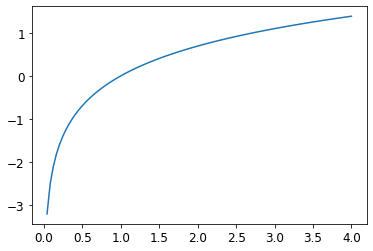

In [43]:
plot_function(torch.log, min=0, max=4)

- The logarithm function has this identity:

    ```
    y = b**a
    a = log(y,b)
    ```

- In this case we're assuming that `log(y,b)` returns $log_b{y}$ (log y base b).

- However, PyTorch actually doesn't define `log` this way: `log` in Python uses the special number `e` (2.718...) as the base.

- The key thing to know about logarithms is this relationship:

    ```
    log(a*b) = log(a) + log(b)
    ```

- It means that logarithms increase linearly when the underlying signal increases exponentially or multiplicatively.

- Using logarithms, modifications which can create really really large and really really small numbers can be replaced by addition which is much less likely to result in scales which are difficult for our computer to handle.

- Taking the mean of the positive or negative log of our probabilities (depending on whether it's the correct or incorrect class) gives us the *negative log likelihood* loss.

- In PyTorch, `nll_loss` assumes that you already took the log of the softmax, so it doesn't actually do the logarithm for you.

- PyTorch has a function called `log_softmax` which combines `log` and `softmax` in a fast and accurate way.

- When we first take the softmax, and then the log likelihood of that, that combination is called *cross entropy loss*.

- In PyTorch, this is available as `nn.CrossEntropyLoss` (which, in practice, actually does `log_softmax` and then `nll_loss`).

In [44]:
loss_func = nn.CrossEntropyLoss()

- As you can see, this is a class.

- Instantiating it gives you an object which behaves like a function.

In [45]:
loss_func(acts, targ)

tensor(1.8045)

- All PyTorch functions are provided in two forms: the class form seen above, and also a plain functional form, available in the `F` namespace:

In [46]:
F.cross_entropy(acts, targ)

tensor(1.8045)

- Either one works fine and can be used in any situation.

- We've noticed that most people tend to use the class version, and that's more often used in PyTorch official docs and examples, so we'll tend to use that too.

- By default PyTorch loss functions take the mean of the loss of all items.

- You can use `reduction='none'` to disable that

In [47]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])